In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from scipy.optimize import curve_fit
from modules.md_utils import coord_initiales_ion, complementaire, longueur_file, longueur_intro
from scipy import stats  

# 25eV, incidence normale

In [2]:
E_incident=25
theta_incident=0

#E_incident=300
#theta_incident=85

In [3]:
long_salve = 500
N_salve=20
T_set = 300 #K
phi_incident = np.random.random()*360 #Degree
nb_step = 1000
dt = 1.e-3 #ps
notebook_adress = os.getcwd()
name_config='Ei_'+str(E_incident)+'_thetai_'+str(theta_incident)

In [4]:
'''### 1ER CALCUL

os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources")
if os.path.exists('Ar_stat2'):
    os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/Ar_stat2")
    if os.path.exists(name_config):
        os.system('rm -r '+str(name_config))
    else:
        os.makedirs(name_config)
else:
    os.makedirs('Ar_stat2')
    os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/Ar_stat2")
    os.makedirs(name_config)
    
Nb_salves_emises=0'''

'### 1ER CALCUL\n\nos.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources")\nif os.path.exists(\'Ar_stat2\'):\n    os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/Ar_stat2")\n    if os.path.exists(name_config):\n        os.system(\'rm -r \'+str(name_config))\n    else:\n        os.makedirs(name_config)\nelse:\n    os.makedirs(\'Ar_stat2\')\n    os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/Ar_stat2")\n    os.makedirs(name_config)\n    \nNb_salves_emises=0'

In [5]:
### REPRISE DU CALCUL
os.chdir(notebook_adress)
with open("MD_Nb_salves_emises_"+name_config+".txt", "rb") as fp:
    Nb_salves_emises = pickle.load(fp)

In [6]:
os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/Ar_stat2/"+name_config)

while Nb_salves_emises < N_salve:
    name_salve='salve_N'+str(Nb_salves_emises+1)
    
    # Préparation de la config
    os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources")
    os.system("make clean")
    os.system("make md2")
    # Tout est stocké dans un nv fichier
    os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/Ar_stat2/"+name_config)
    if os.path.exists(name_salve):
        os.system('rm -r '+name_salve)
    os.makedirs(name_salve)
    os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/Ar_stat2/"+name_config+'/'+name_salve)
    os.makedirs('ion')
    os.makedirs('cfg')
    os.makedirs('clu')
    os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources")
    os.system("cp -R cfg/ Ar_stat2/"+name_config+'/'+name_salve+'/cfg')
    os.system("cp md2 Ar_stat2/"+name_config+'/'+name_salve+'/md2')

    # Run
    os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/Ar_stat2/"+name_config+'/'+name_salve)
    command="./md2 -oc cfg/####.cfg -ion Ar"
    command+=" -ionE " + str(E_incident) + " -Tset " + str(T_set) + " -ionT " + str(theta_incident)
    command+=" -tau " + str(0.01) +" -n " + str(nb_step) 
    command+=" -dt " + str(dt) + " +dtv " + " -i1 " + str(long_salve) 
    #command+=" > log 􏰬&"

    os.system(command)

    Nb_salves_emises+=1
    phi_incident=np.random.random()*360
    
    os.chdir(notebook_adress)
    with open("MD_Nb_salves_emises_"+name_config+".txt", "wb") as fp:
        pickle.dump(Nb_salves_emises, fp)
    os.chdir("/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/Ar_stat2/"+name_config)
    print('salve '+str(Nb_salves_emises)+' faite')
    
print("toutes les salves sont faites")

toutes les salves sont faites


In [7]:
critere_out=-2 #d.z>=critere_out

for i in range(N_salve):
    name_salve='salve_N'+str(i+1)
    for j in range(long_salve):
        path = r"/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/Ar_stat2/"+name_config+'/'+name_salve+"/ion/"+complementaire(j)+".ion"
        long=longueur_file(path)

        df_intermediaire=pd.read_csv(path, header=None,usecols=np.arange(0,10).tolist(), skiprows=long-2, names=['Time step','Integration time','KE/TE_i','internal PE','external PE','d.x','d.y','d.z','norm(d)','#b','imp?'],sep="[:,; ]",engine='python')
        dx=df_intermediaire['d.x'].values[-1]-df_intermediaire['d.x'].values[-2]
        dy=df_intermediaire['d.y'].values[-1]-df_intermediaire['d.y'].values[-2]
        dz=df_intermediaire['d.z'].values[-1]-df_intermediaire['d.z'].values[-2]
        dr=np.sqrt(dx**2+dy**2+dz**2)
        theta_sortie=np.arccos(dz/dr)*180/np.pi
        phi_sortie=np.arctan(dy/dx)*180/np.pi
        out=(df_intermediaire['d.z']>=critere_out)

        if i==0 and j==0:
            df=pd.read_csv(path, header=None,usecols=np.arange(0,10).tolist(), skiprows=long-1, names=['Time step','Integration time','KE/TE_i','internal PE','external PE','d.x','d.y','d.z','norm(d)','#b','imp?'],sep="[:,; ]",engine='python')
            df['theta_f']=theta_sortie
            df['Out?']=out
        else:
            line=pd.read_csv(path, header=None,usecols=np.arange(0,10).tolist(), skiprows=long-1, names=['Time step','Integration time','KE/TE_i','internal PE','external PE','d.x','d.y','d.z','norm(d)','#b','imp?'],sep="[:,; ]",engine='python')
            line['theta_f']=theta_sortie
            line['Out?']=out
            frames = [df, line]
            df = pd.concat(frames)
    print(name_salve+' lue')
        
df=df.reset_index()
df.drop(['index','Time step', 'Integration time', '#b', 'd.x', 'd.y', 'd.z', 'norm(d)'], axis='columns', inplace=True)
indexNames = df[ df['Out?'] == False ].index
df.drop(indexNames , inplace=True)
print(df)

salve_N1 lue
salve_N2 lue
salve_N3 lue
salve_N4 lue
salve_N5 lue
salve_N6 lue


/Users/edouardroger/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


salve_N7 lue
salve_N8 lue
salve_N9 lue
salve_N10 lue
salve_N11 lue
salve_N12 lue
salve_N13 lue
salve_N14 lue
salve_N15 lue
salve_N16 lue
salve_N17 lue
salve_N18 lue
salve_N19 lue
salve_N20 lue
       KE/TE_i  internal PE  external PE    theta_f  Out?
3     0.052426          0.0          0.0  67.048636  True
4     0.021996          0.0          0.0  22.339226  True
5     0.028661          0.0          0.0  21.922566  True
14    0.031274          0.0          0.0  38.947956  True
15    0.038864          0.0          0.0  18.199958  True
...        ...          ...          ...        ...   ...
9989  0.163601          0.0          0.0  64.735312  True
9991  0.106076          0.0          0.0  56.961965  True
9992  0.105103          0.0          0.0  24.179313  True
9994  0.033499          0.0          0.0  23.329039  True
9998  0.052042          0.0          0.0  35.148308  True

[5463 rows x 5 columns]


In [8]:
def f(x,K1,K2,delta,n):
    return K1*x**n/(1+K2*np.exp(x/delta))

def fbis(x,K1,K2,delta,n):
    xbis=np.abs(1-x)
    return K1*xbis**n/(1+K2*np.exp(xbis/delta))

def g(x,K,mu,sigma):
    x_centre_red=(x-mu)/sigma
    prefacteur=1/(sigma*np.sqrt(2*np.pi))
    return K*prefacteur*np.exp(-.5*x_centre_red**2)

In [9]:
def h(x,K1,K2):
    return K2*np.sqrt(K1*np.abs(x))*np.exp(-K1*np.abs(x))

def hbis(x,K1,K2,m):
    xbis=m-x
    return h(K1,K2,xbis)

K1E=19.574100906662338, K2E=1300.3261530233358
K1T=0.0338537784402866, K2T=643.153831483179


/Users/edouardroger/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


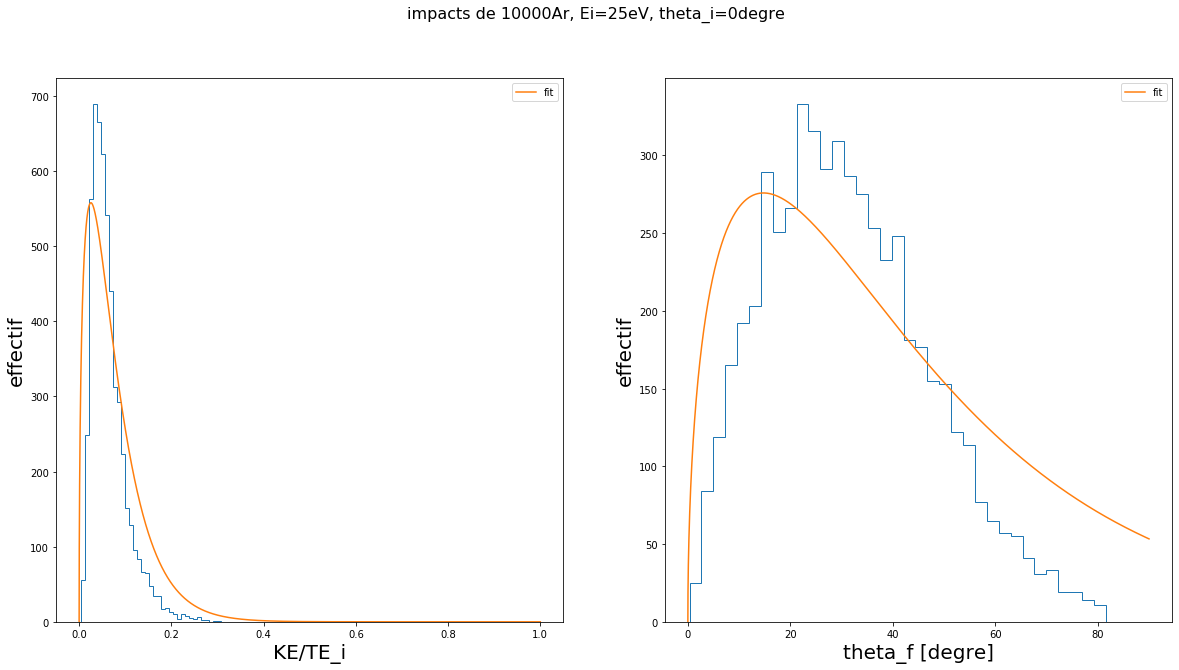

In [14]:
res=35
opt=True

if opt==True:
    
    xmin=0.95*np.min(df['KE/TE_i'])
    xmax=1.05*np.max(df['KE/TE_i'])
    abscisse1 = np.linspace(0, 1, 100000)
    data, bins = np.histogram(df['KE/TE_i'], bins=np.linspace(xmin, xmax, res))
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    if theta_incident==0:
        p0=[1,1]
        bounds=np.array([0,0]),np.array([1000,1000000])
        popt, pcov = curve_fit(h, xdata=binscenters, ydata=data, p0=p0,bounds=bounds)
        K1E, K2E=popt[0], popt[1]
        ordonnee1 = h(abscisse1,K1E, K2E)
    else:
        p0=[1,1,1]
        bounds=np.array([0,0,.95]),np.array([1000,1000000,1.05])
        popt, pcov = curve_fit(hbis, xdata=binscenters, ydata=data, p0=p0,bounds=bounds)
        K1E, K2E, m=popt[0], popt[1], popt[2]
        ordonnee1 = hbis(abscisse1,K1E, K2E,m)
    
    xmin=0.95*np.min(df['theta_f'])
    xmax=1.05*np.max(df['theta_f'])
    abscisse2 = np.linspace(0, 90, 100000)
    data, bins = np.histogram(df['theta_f'], bins=np.linspace(xmin, xmax, res))
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    if theta_incident==0:
        p0=[1,1]
        bounds=np.array([0,0]),np.array([1000,1000000])
        popt, pcov = curve_fit(h, xdata=binscenters, ydata=data, p0=p0,bounds=bounds)
        K1T, K2T=popt[0], popt[1]
        ordonnee2 = h(abscisse2,K1T, K2T)
    else:
        p0=[1,1,90]
        bounds=np.array([0,0,89]),np.array([1000,1000000,91])
        popt, pcov = curve_fit(hbis, xdata=binscenters, ydata=data, p0=p0,bounds=bounds)
        K1T, K2T, m=popt[0], popt[1], popt[2]
        ordonnee2 = hbis(abscisse2,K1T, K2T,m)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)

ax1.hist(df['KE/TE_i'], density=False, histtype='step',bins=res)
ax1.set_xlabel('KE/TE_i',size=20)
ax1.set_ylabel('effectif',size=20)
if opt==True:
    ax1.plot(abscisse1,ordonnee1,label='fit')
    ax1.legend()
    print('K1E='+str(K1E)+', K2E='+str(K2E))

ax2 = fig.add_subplot(1,2,2)

ax2.hist(df['theta_f'], density=False, histtype='step',bins=res)
ax2.set_xlabel('theta_f [degre]',size=20)
ax2.set_ylabel('effectif',size=20)
if opt==True:
    ax2.plot(abscisse2,ordonnee2,label='fit')
    ax2.legend()
    print('K1T='+str(K1T)+', K2T='+str(K2T))

fig.suptitle('impacts de '+str(N_salve*long_salve)+'Ar, Ei='+str(E_incident)+'eV, theta_i='+str(theta_incident)+'degre', fontsize=16)
fig.show()

K1=24601864.710645907, K2=1.684485068402551, delta=0.016937682344484128, n=2.309515898680163
K=15001.907237680418, mu=28.321739526531125, sigma=17.322659541853803


/Users/edouardroger/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


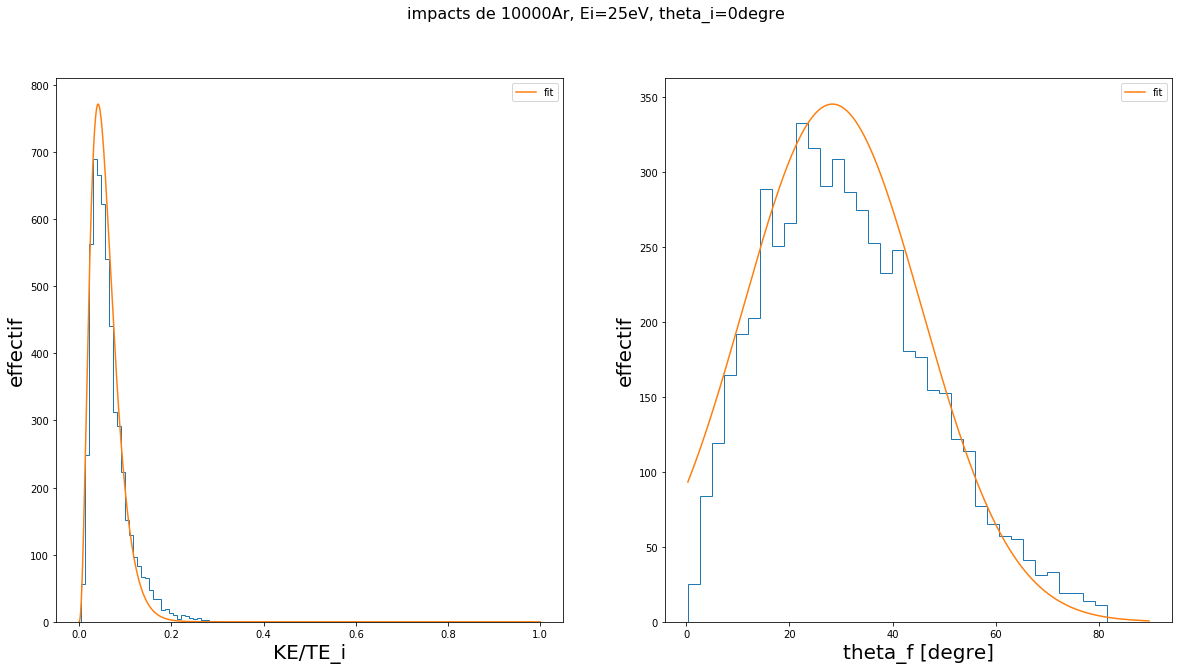

In [9]:
"""res=35
opt=True

if opt==True:
    xmin=0.9*np.min(df['KE/TE_i'])
    xmax=1.1*np.max(df['KE/TE_i'])
    abscisse1 = np.linspace(0, 1, 100000)
    data, bins = np.histogram(df['KE/TE_i'], bins=np.linspace(xmin, xmax, res))
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    if theta_incident==0: 
        p0=[1,1,1,1] 
        popt, pcov = curve_fit(f, xdata=binscenters, ydata=data, p0=p0)
        K1, K2, delta,n=popt[0], popt[1], popt[2], popt[3]
        ordonnee1 = f(abscisse1,K1, K2, delta,n)
    else: 
        p0=[2500,1,.2,1]
        bounds=np.array([1,0,0,0]),np.array([1000000,10000,1000,10])
        popt, pcov = curve_fit(fbis, xdata=binscenters, ydata=data, p0=p0,bounds=bounds)
        K1, K2, delta,n=popt[0], popt[1], popt[2], popt[3]
        ordonnee1 = fbis(abscisse1,K1, K2, delta,n)

    xmin=0.9*np.min(df['theta_f'])
    xmax=1.1*np.max(df['theta_f'])
    data, bins = np.histogram(df['theta_f'], bins=np.linspace(xmin, xmax, res))
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    if theta_incident==0: 
        p0=[1,1,1]
    else: 
        p0=[2000,80,5]
    popt, pcov = curve_fit(g, xdata=binscenters, ydata=data, p0=p0)
    K, mu, sigma=popt[0], popt[1], popt[2]
    abscisse2 = np.linspace(xmin, xmax, 100000)
    ordonnee2 = g(abscisse2,K, mu, sigma)
    

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)

ax1.hist(df['KE/TE_i'], density=False, histtype='step',bins=res)
ax1.set_xlabel('KE/TE_i',size=20)
ax1.set_ylabel('effectif',size=20)
if opt==True:
    ax1.plot(abscisse1,ordonnee1,label='fit')
    ax1.legend()
    print('K1='+str(K1)+', K2='+str(K2)+', delta='+str(delta)+', n='+str(n))

ax2 = fig.add_subplot(1,2,2)

ax2.hist(df['theta_f'], density=False, histtype='step',bins=res)
ax2.set_xlabel('theta_f [degre]',size=20)
ax2.set_ylabel('effectif',size=20)
if opt==True:
    ax2.plot(abscisse2,ordonnee2,label='fit')
    ax2.legend()
    print('K='+str(K)+', mu='+str(mu)+', sigma='+str(sigma))

fig.suptitle('impacts de '+str(N_salve*long_salve)+'Ar, Ei='+str(E_incident)+'eV, theta_i='+str(theta_incident)+'degre', fontsize=16)
fig.show()"""